<h5><font color='039affff'><b>Part 3</b></font></h5>
We are now at the final part of the whole project! Here, we will conduct the resale price analysis.

Importing libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge

import pickle

Import data previously used

In [48]:
with open('random_forest_model.pkl', 'rb') as f: #Get model
    rf_model = pickle.load(f)

with open('feature_names.json', 'r') as f: #Get feature names
    feature_names = json.load(f)

#Load data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
y_train = pd.DataFrame(y_train, columns=['resale_price'])
y_test = pd.DataFrame(y_test, columns=['resale_price'])

<h5><font color='039affff'><b>Resale price analysis</b></font></h5>

Using the model we trained (Random Forest), we can also pick out which feature is the most important to it when predicting resale prices

Random Forest Feature Importance:


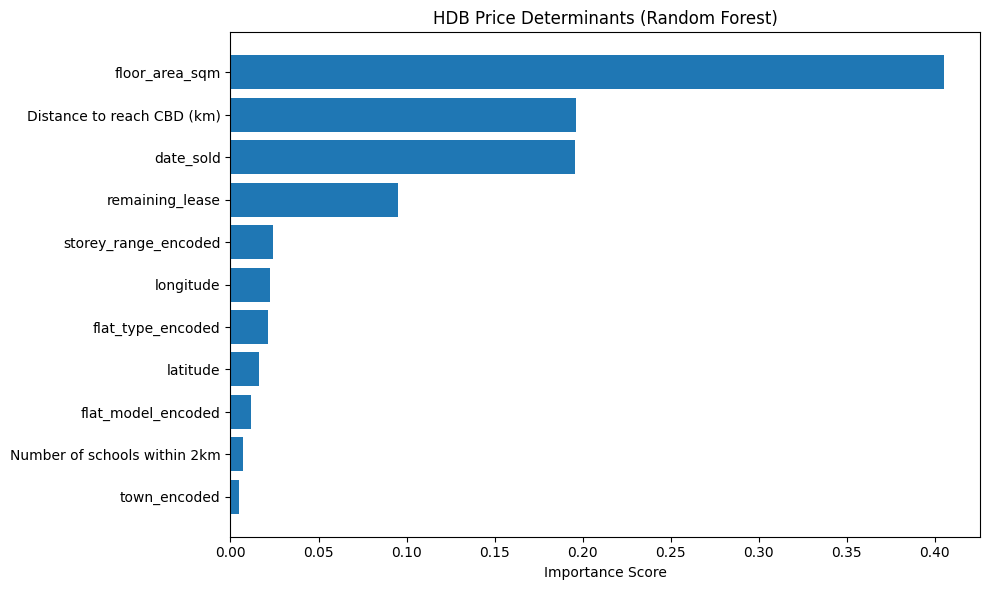

In [49]:
# Get feature importance
importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance Score')
plt.title('HDB Price Determinants (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Despite having a weak correlation with the resale price, Random Forest still had the distance to reach CBD the second most important feature. This is because correlation shows how each feature affects price in isolation, assuming a linear relationship. However, since features affects prices collectively instead of individually, the scores provided by Random Forest are more accurate. Features can become more important if they are useful when working with other features.

However, tree models cannot provide interpretable linear coefficients, making it hard to quantify each feature’s marginal effect. Thus, if we want a model that is able to provide coefficients to each feature, we should use a regularised linear regression model. It helps prevent overfitting, preventing extreme values from being predicted. An example of a regularised linear regression model is Ridge. Since Singapore is small, we can remove latitude and longitude as the margins will be too small to be useful.

**Ridge is used solely for identifying coefficients, something tree models cannot offer. For predicting, the random forest model from part 2 is more accurate

In [ ]:
X_train.drop(columns=['latitude', 'longitude'], inplace=True)
X_test.drop(columns=['latitude', 'longitude'], inplace=True)

# Scale for Ridge
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Ridge with reasonable alpha
ridge = Ridge(alpha=100)  # Medium regularization
ridge.fit(X_train_scaled, y_train)

print(f"Ridge Test R²: {ridge.score(X_test_scaled, y_test):.3f}")

scale = scaler.scale_    # IQR of each feature
effect_per_unit = ridge.coef_ / scale # Δy per 1 unit of original X

# Get coefficients 
coef_df = pd.DataFrame({
    'feature': X_test.columns,
    'coefficient': ridge.coef_,
    'effect_per_unit': effect_per_unit,  
})

print("Ridge Coefficients for Interpretation:")
print(coef_df.sort_values('effect_per_unit', key=abs, ascending=False))

# Define units to match features
units_dict = {'flat_type_encoded': 'room type unit','floor_area_sqm': 'sqm','lease_commence_date': 'year','remaining_lease': 'year',
              'Number of schools within 2km': 'school','storey_range_encoded': 'storey level','Distance to reach CBD (km)': 'km',
              'flat_model_encoded': 'model type','town_encoded': 'town code', 'date_sold': 'year'
}

# Create proper interpretation table
interpretation_df = pd.DataFrame({
    'feature': X_test.columns,
    'coefficient': ridge.coef_,
    'effect_per_unit': effect_per_unit  
})

# Add units based on feature names
interpretation_df['unit'] = interpretation_df['feature'].map(units_dict)

# Sort by absolute effect size
interpretation_df = interpretation_df.sort_values('coefficient', key=abs, ascending=False)

print("\n📊 RIDGE COEFFICIENTS:")
print("-" * 80)

for _, row in interpretation_df.iterrows():
    coef = row['effect_per_unit']  
    effect = f"+${coef:,.0f}" if coef > 0 else f"-${abs(coef):,.0f}"
    
    print(f"{row['feature']:26}: {effect} per {row['unit']}")

#Check if values make sense
print("\n" + "="*30)
print("Logic check:")
print("="*30)

# Sanity check 1: Floor area
avg_flat_sqm = X_train['floor_area_sqm'].mean()
price_per_sqm = interpretation_df.loc[interpretation_df['feature']=='floor_area_sqm', 'effect_per_unit'].values[0]
print(f"Average flat: {avg_flat_sqm:.0f} sqm × ${price_per_sqm:,.0f}/sqm = ${avg_flat_sqm * price_per_sqm:,.0f} size premium")

# Sanity check 2: Distance to CBD
avg_distance = X_train['Distance to reach CBD (km)'].mean()
price_per_km = interpretation_df.loc[interpretation_df['feature']=='Distance to reach CBD (km)', 'effect_per_unit'].values[0]
print(f"Average distance: {avg_distance:.1f} km × ${price_per_km:,.0f}/km = ${avg_distance * price_per_km:,.0f} location discount")

Ridge Test R²: 0.816
Ridge Coefficients for Interpretation:
                        feature    coefficient  effect_per_unit
7    Distance to reach CBD (km) -112243.710591    -19166.208153
0             flat_type_encoded   26652.222646     13326.111323
3          storey_range_encoded   32639.053511      5439.842252
1                floor_area_sqm  146876.137246      4737.939911
4               remaining_lease  116036.251296      4434.506419
8            flat_model_encoded    9869.153490      1409.879070
5  Number of schools within 2km   -7489.819049      -936.227381
6                  town_encoded    5629.691227       433.053171
2                     date_sold  133119.369892       329.503391

📊 RIDGE COEFFICIENTS:
--------------------------------------------------------------------------------
floor_area_sqm            : +$4,738 per sqm
date_sold                 : +$330 per year
remaining_lease           : +$4,435 per year
Distance to reach CBD (km): -$19,166 per km
storey_range_encoded

<h5><font color='039affff'><b>Insights & Takeaways</b></font></h5> 

With this Ridge model, we are able to explain 81.6% of the variance in prices. We also obtained rough estimates in how each feature affects the price. For example, for every square metre of area, the price could go up by $4738. Interestingly, for every school nearby, the price drops by $936. This suggests that parents may not be looking to change houses or if they intend to do so, flats near schools are not of priority for them.

This project also further confirmed that HDB prices are not linearly related and exhibit heteroscedasticity, meaning higher-priced flats have more unpredictable pricing. This accurately reflects the real-world volatility and uniqueness of the housing market, where one feature does not directly affect the price of a unit. 

With this project, we have been able to identify value patterns, showing that with informed decisions, the resale values can be reasonably predicted

<strong>Statistical limitations:</strong><br><br>
In this statistical analysis, several limitations were faced: <ol>
<li>Timeframe: The dataset only contains information from 2017 onwards</li>
<li>Interior variables: This analysis was based solely on fixed variables such as lease dates and locations, not taking into account information such as renovations done to the house</li>
<li>The ROI cannot be predicted since the original price when the flat was bought is not provided</li>